# Capstone Project 
## Part 2 - Identifying 'systemised' listings

## Network Analysis - Dec 20 data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import networkx as nx
from pyvis.network import Network
from networkx.algorithms import bipartite

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set_theme(context='notebook', style='darkgrid', palette='deep', font_scale=1.5)

In [2]:
# load data
df = pd.read_csv('../../GA/capstone-data-airbnb/merged_network_data_dec20.csv')
df.shape

(1156947, 8)

### Calculate reviews per host and reviews per reviewer

In [3]:
# calculate reviews per host
host_review_counts = df.groupby('host_id')[['listing_id']].count().reset_index()
host_review_counts.rename(columns={'listing_id': 'host_review_count'}, inplace=True)

# calculate reviews per reviewer
reviewer_review_counts = df.groupby('reviewer_id')[['listing_id']].count().reset_index()
reviewer_review_counts.rename(columns={'listing_id': 'reviewer_review_count'}, inplace=True)

# calculate number of listings by host
host_listing_counts = df.groupby(['host_id', 'listing_id'])[['id']].count().reset_index().drop(columns=['id']) \
                        .groupby('host_id')[['listing_id']].count().reset_index()
host_listing_counts.rename(columns={'listing_id': 'host_listing_count'}, inplace=True)

# calculate number of hosts reviewed by reviewer
reviewer_host_counts = df.groupby(['reviewer_id', 'host_id'])[['id']].count().reset_index().drop(columns=['id']) \
                         .groupby('reviewer_id')[['host_id']].count().reset_index()
reviewer_host_counts.rename(columns={'host_id': 'reviewer_host_count'}, inplace=True)

In [4]:
df = pd.merge(df, host_review_counts, how='left', on='host_id')
df = pd.merge(df, reviewer_review_counts, how='left', on='reviewer_id')
df = pd.merge(df, host_listing_counts, how='left', on='host_id')
df = pd.merge(df, reviewer_host_counts, how='left', on='reviewer_id')
df.shape

(1156947, 12)

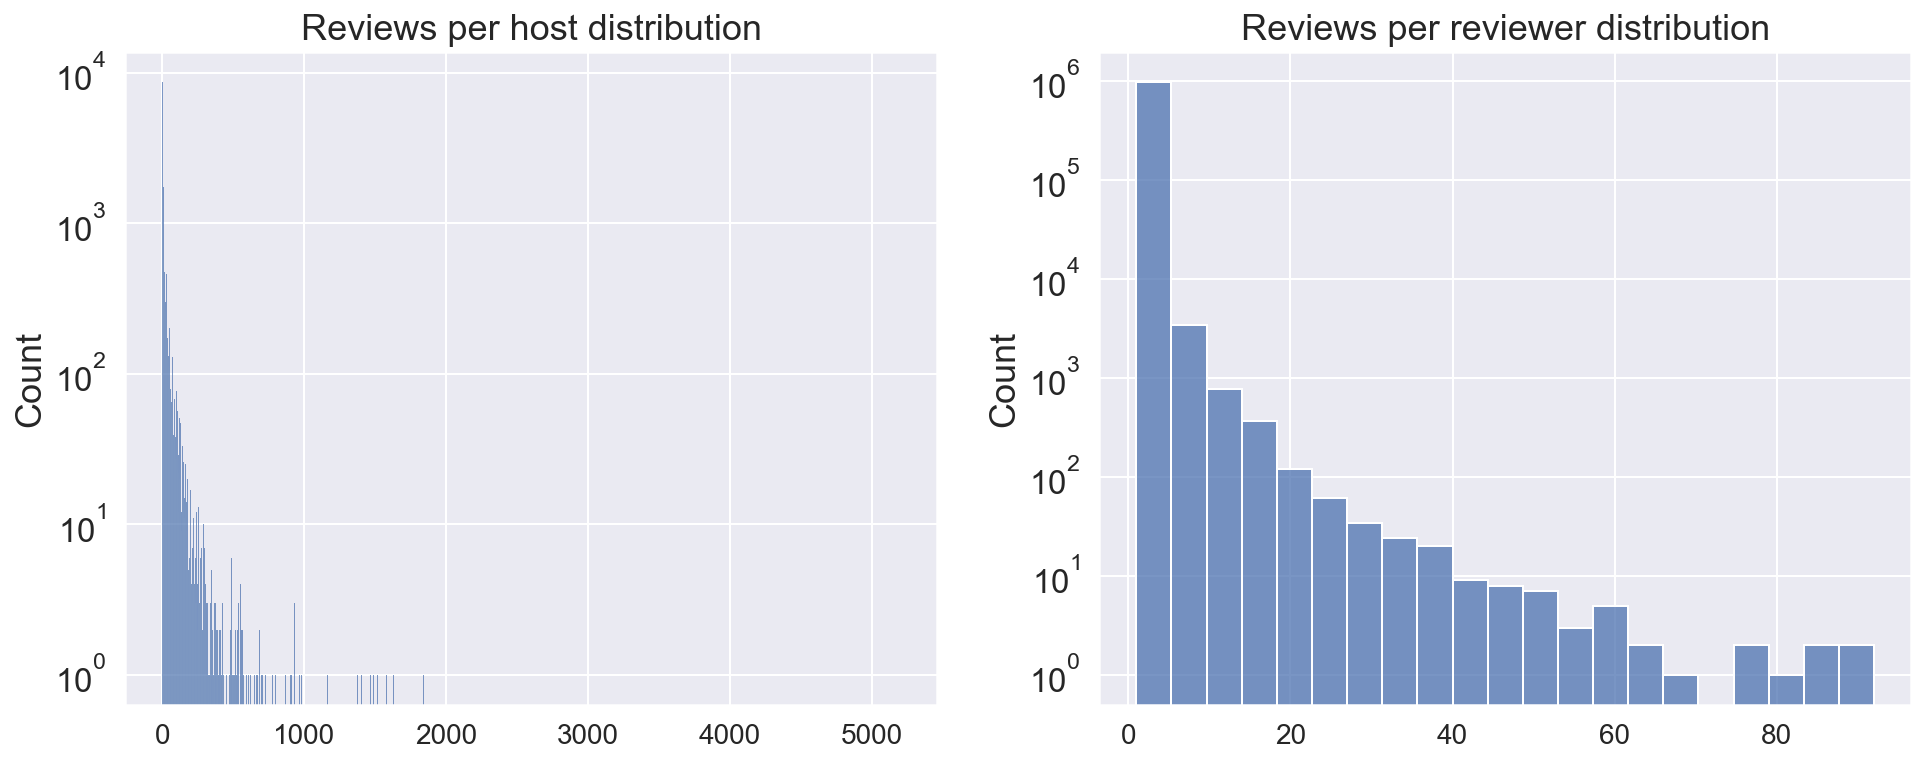

In [5]:
# plot histograms of host counts and reviewer counts
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
sns.histplot(host_review_counts.host_review_count, ax=ax[0])
sns.histplot(reviewer_review_counts.reviewer_review_count, ax=ax[1])
ax[0].set_title('Reviews per host distribution')
ax[1].set_title('Reviews per reviewer distribution')

for a in ax:
    a.set_xlabel('')
    a.tick_params(axis='x', labelsize=14, labelrotation=0)
    a.set_yscale('log')

plt.show()

### Create subset of reviewers / hosts with indicators of systemised listings / fake reviews for analysis

1. Only include hosts and reviewers where reviewers have left multiple reviews for a host (can be for different listings)
2. Only include hosts with multiple listings
3. Only include reviewers who have reviewed at least three hosts
4. Exclude multiple reviews from a reviewer for a listing which occur on the same date

In [6]:
subset = df[df.duplicated(subset=['host_id', 'reviewer_id'], keep=False)].copy()
subset = subset[subset.host_listing_count >= 5]
subset = subset[subset.reviewer_host_count > 2]
subset.drop_duplicates(subset=['host_id', 'reviewer_id', 'listing_id', 'date'], keep=False, inplace=True)
subset.shape

(3654, 12)

In [7]:
print('Number of reviewers: ', len(subset.reviewer_id.unique()))
print('Number of hosts: ', len(subset.host_id.unique()))

Number of reviewers:  1059
Number of hosts:  362


### Network analysis

#### Useful functions

In [8]:
def component_size_one(G):
    '''Take a graph G and return a list of the 
       connected components of size 1 and the
       number of connected components of size 1'''
    components = [list(G) for G in nx.connected_components(G) if len(G) == 1]
    num_components = len(components)
    return components, num_components

In [9]:
def giant_component_size(G):
    '''Take a graph G and return the largest connected component, 
        a list of the connected components > 1 and 
        the number of connected components > 1'''
    components = [(len(G), list(G)) for G in nx.connected_components(G) if len(G) > 1]
    num_components = len(components)
    GCC = [y[1] for y in components if y[0]
           == max([x[0] for x in components])][0]
    return GCC, components, num_components

In [10]:
# create dictionary for labels
hosts = dict(subset[['host_id', 'host_name']].values)
reviewers = dict(subset[['reviewer_id', 'reviewer_name']].values)
labels_dict = {**reviewers, **hosts}

#### Network analysis

In [11]:
G = nx.Graph()
G.add_nodes_from(subset.reviewer_id.unique(), bipartite=0)
G.add_nodes_from(subset.host_id.unique(), bipartite=1)
G.add_edges_from(subset[['reviewer_id', 'host_id']].values)

In [12]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1421
Number of edges: 1228
Average degree:   1.7284


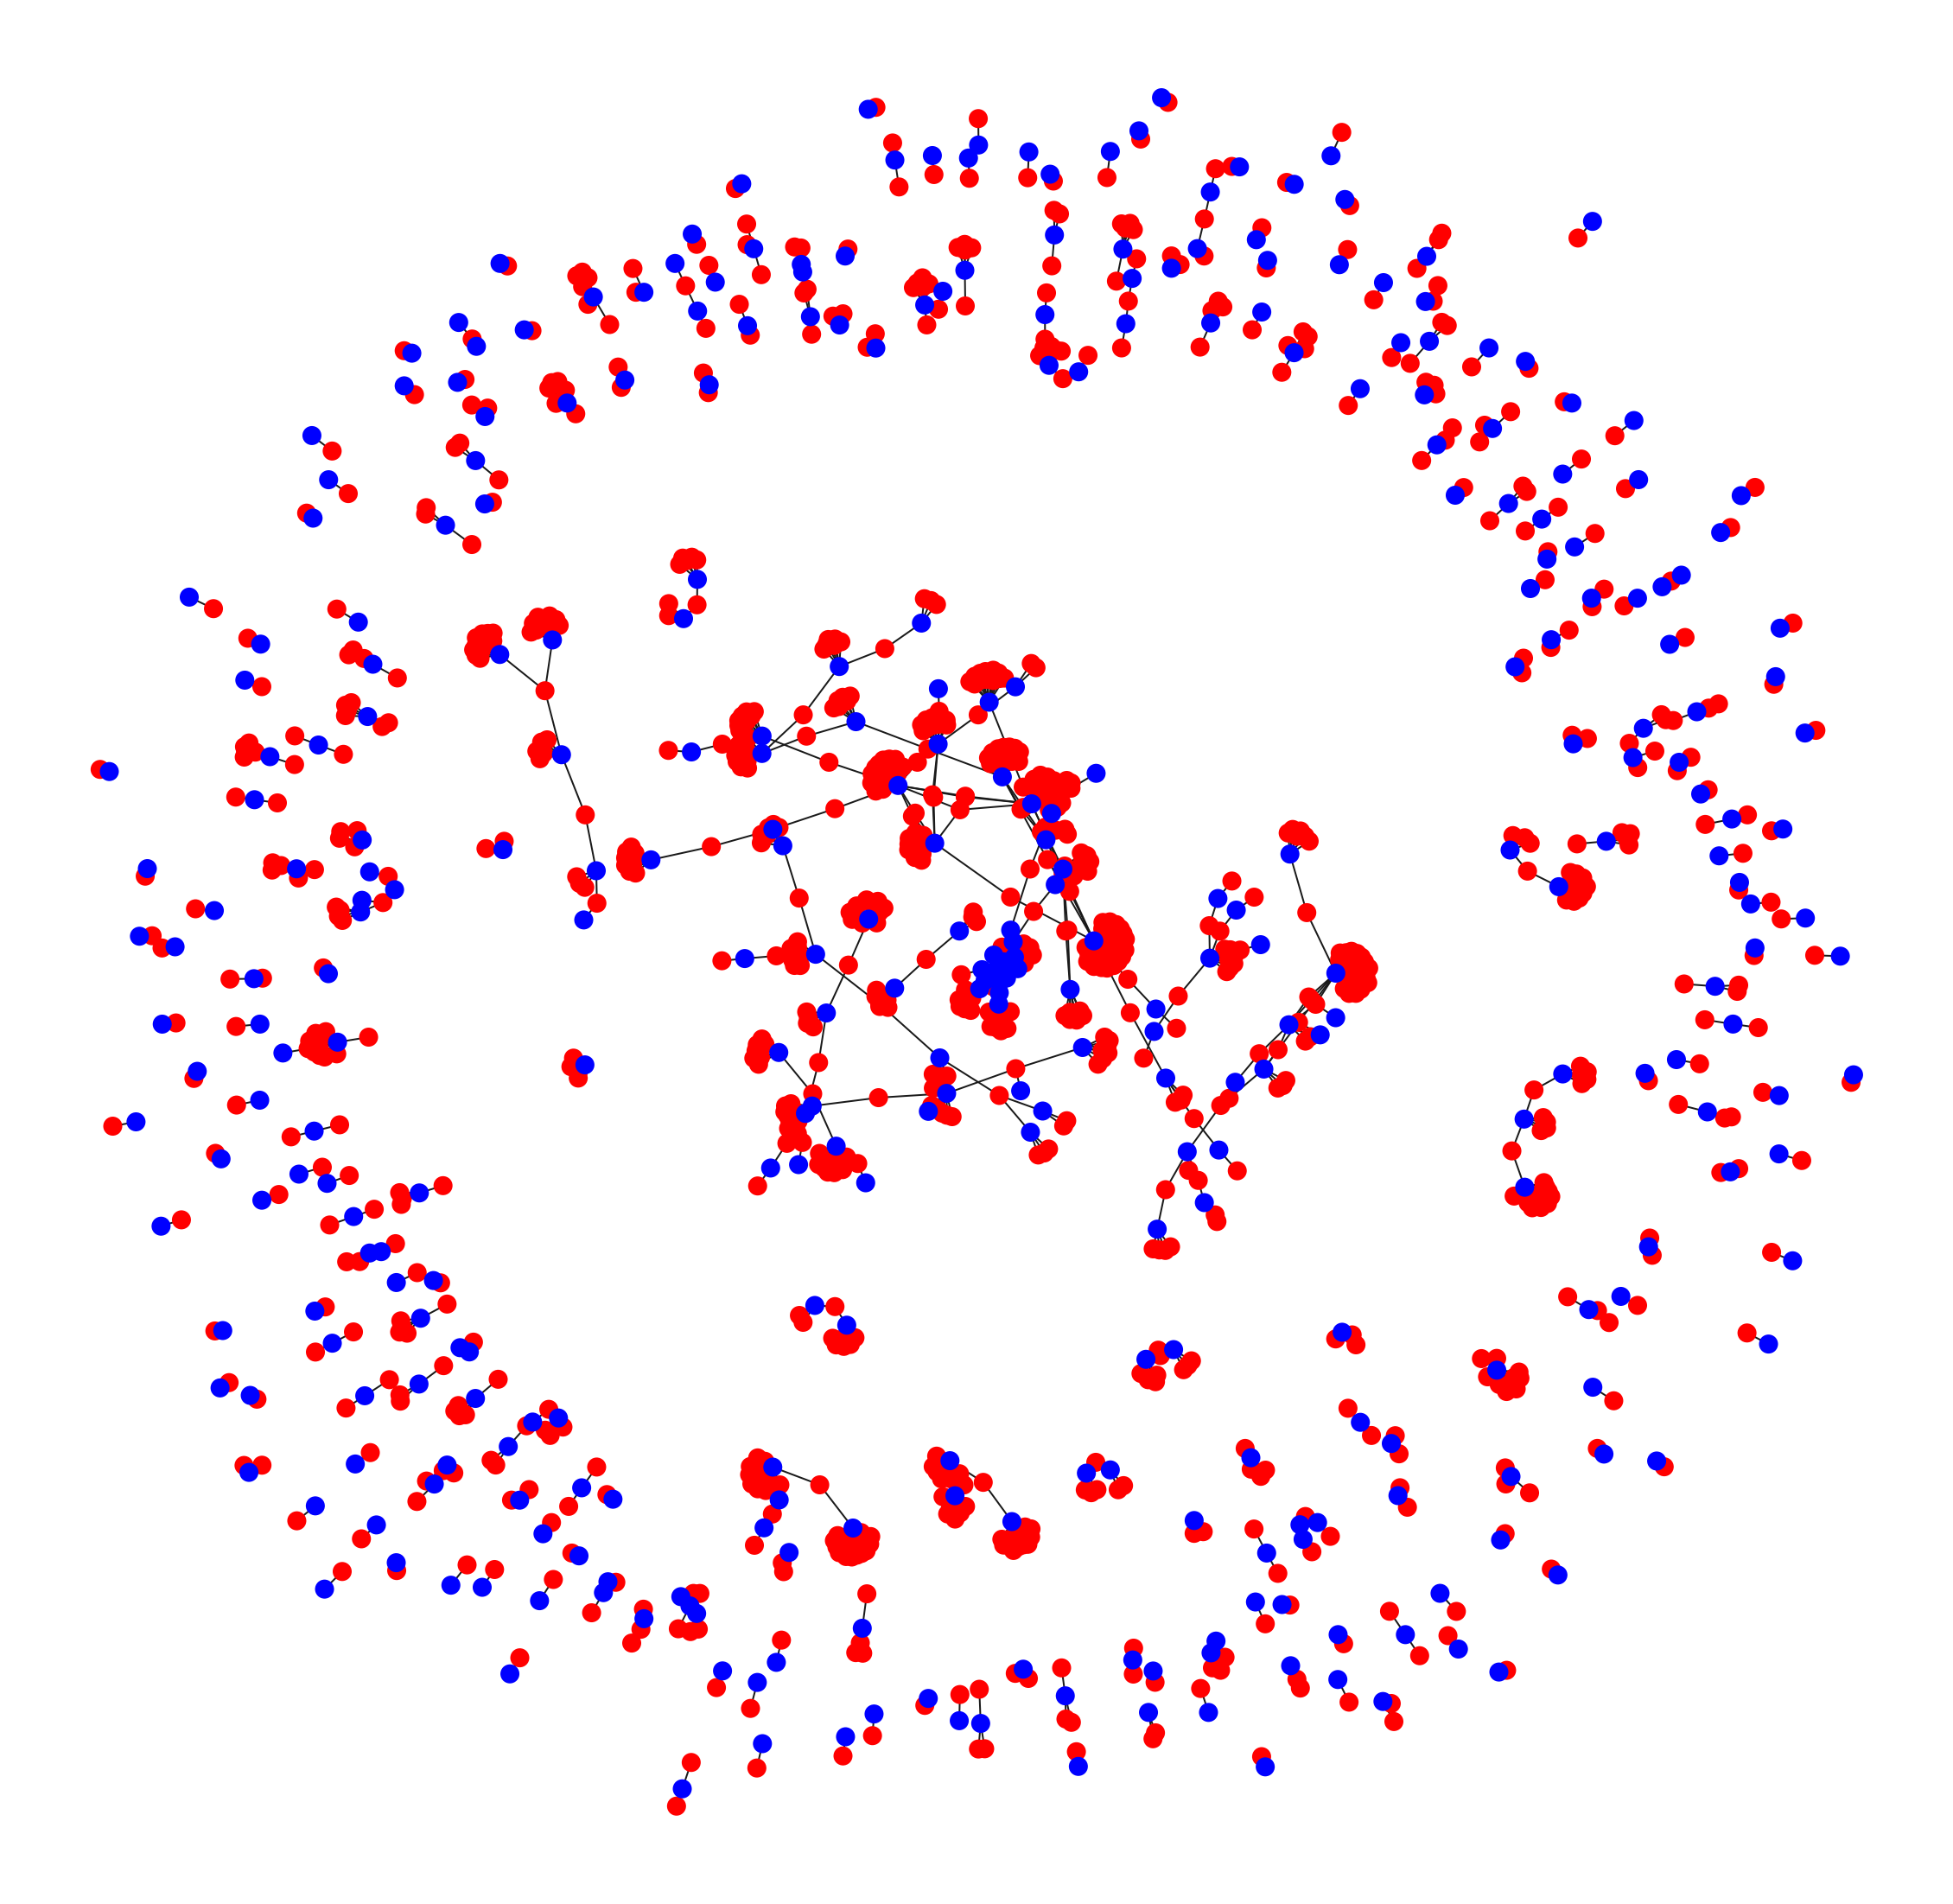

In [13]:
# nodes
reviewer_nodes = subset.reviewer_id.unique()
host_nodes = subset.host_id.unique()

# create plot
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, seed=1)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=['red']*len(reviewer_nodes) +
        ['blue']*(len(host_nodes)))
nx.draw_networkx_edges(G, pos, width=1)
plt.axis("off")
plt.show()

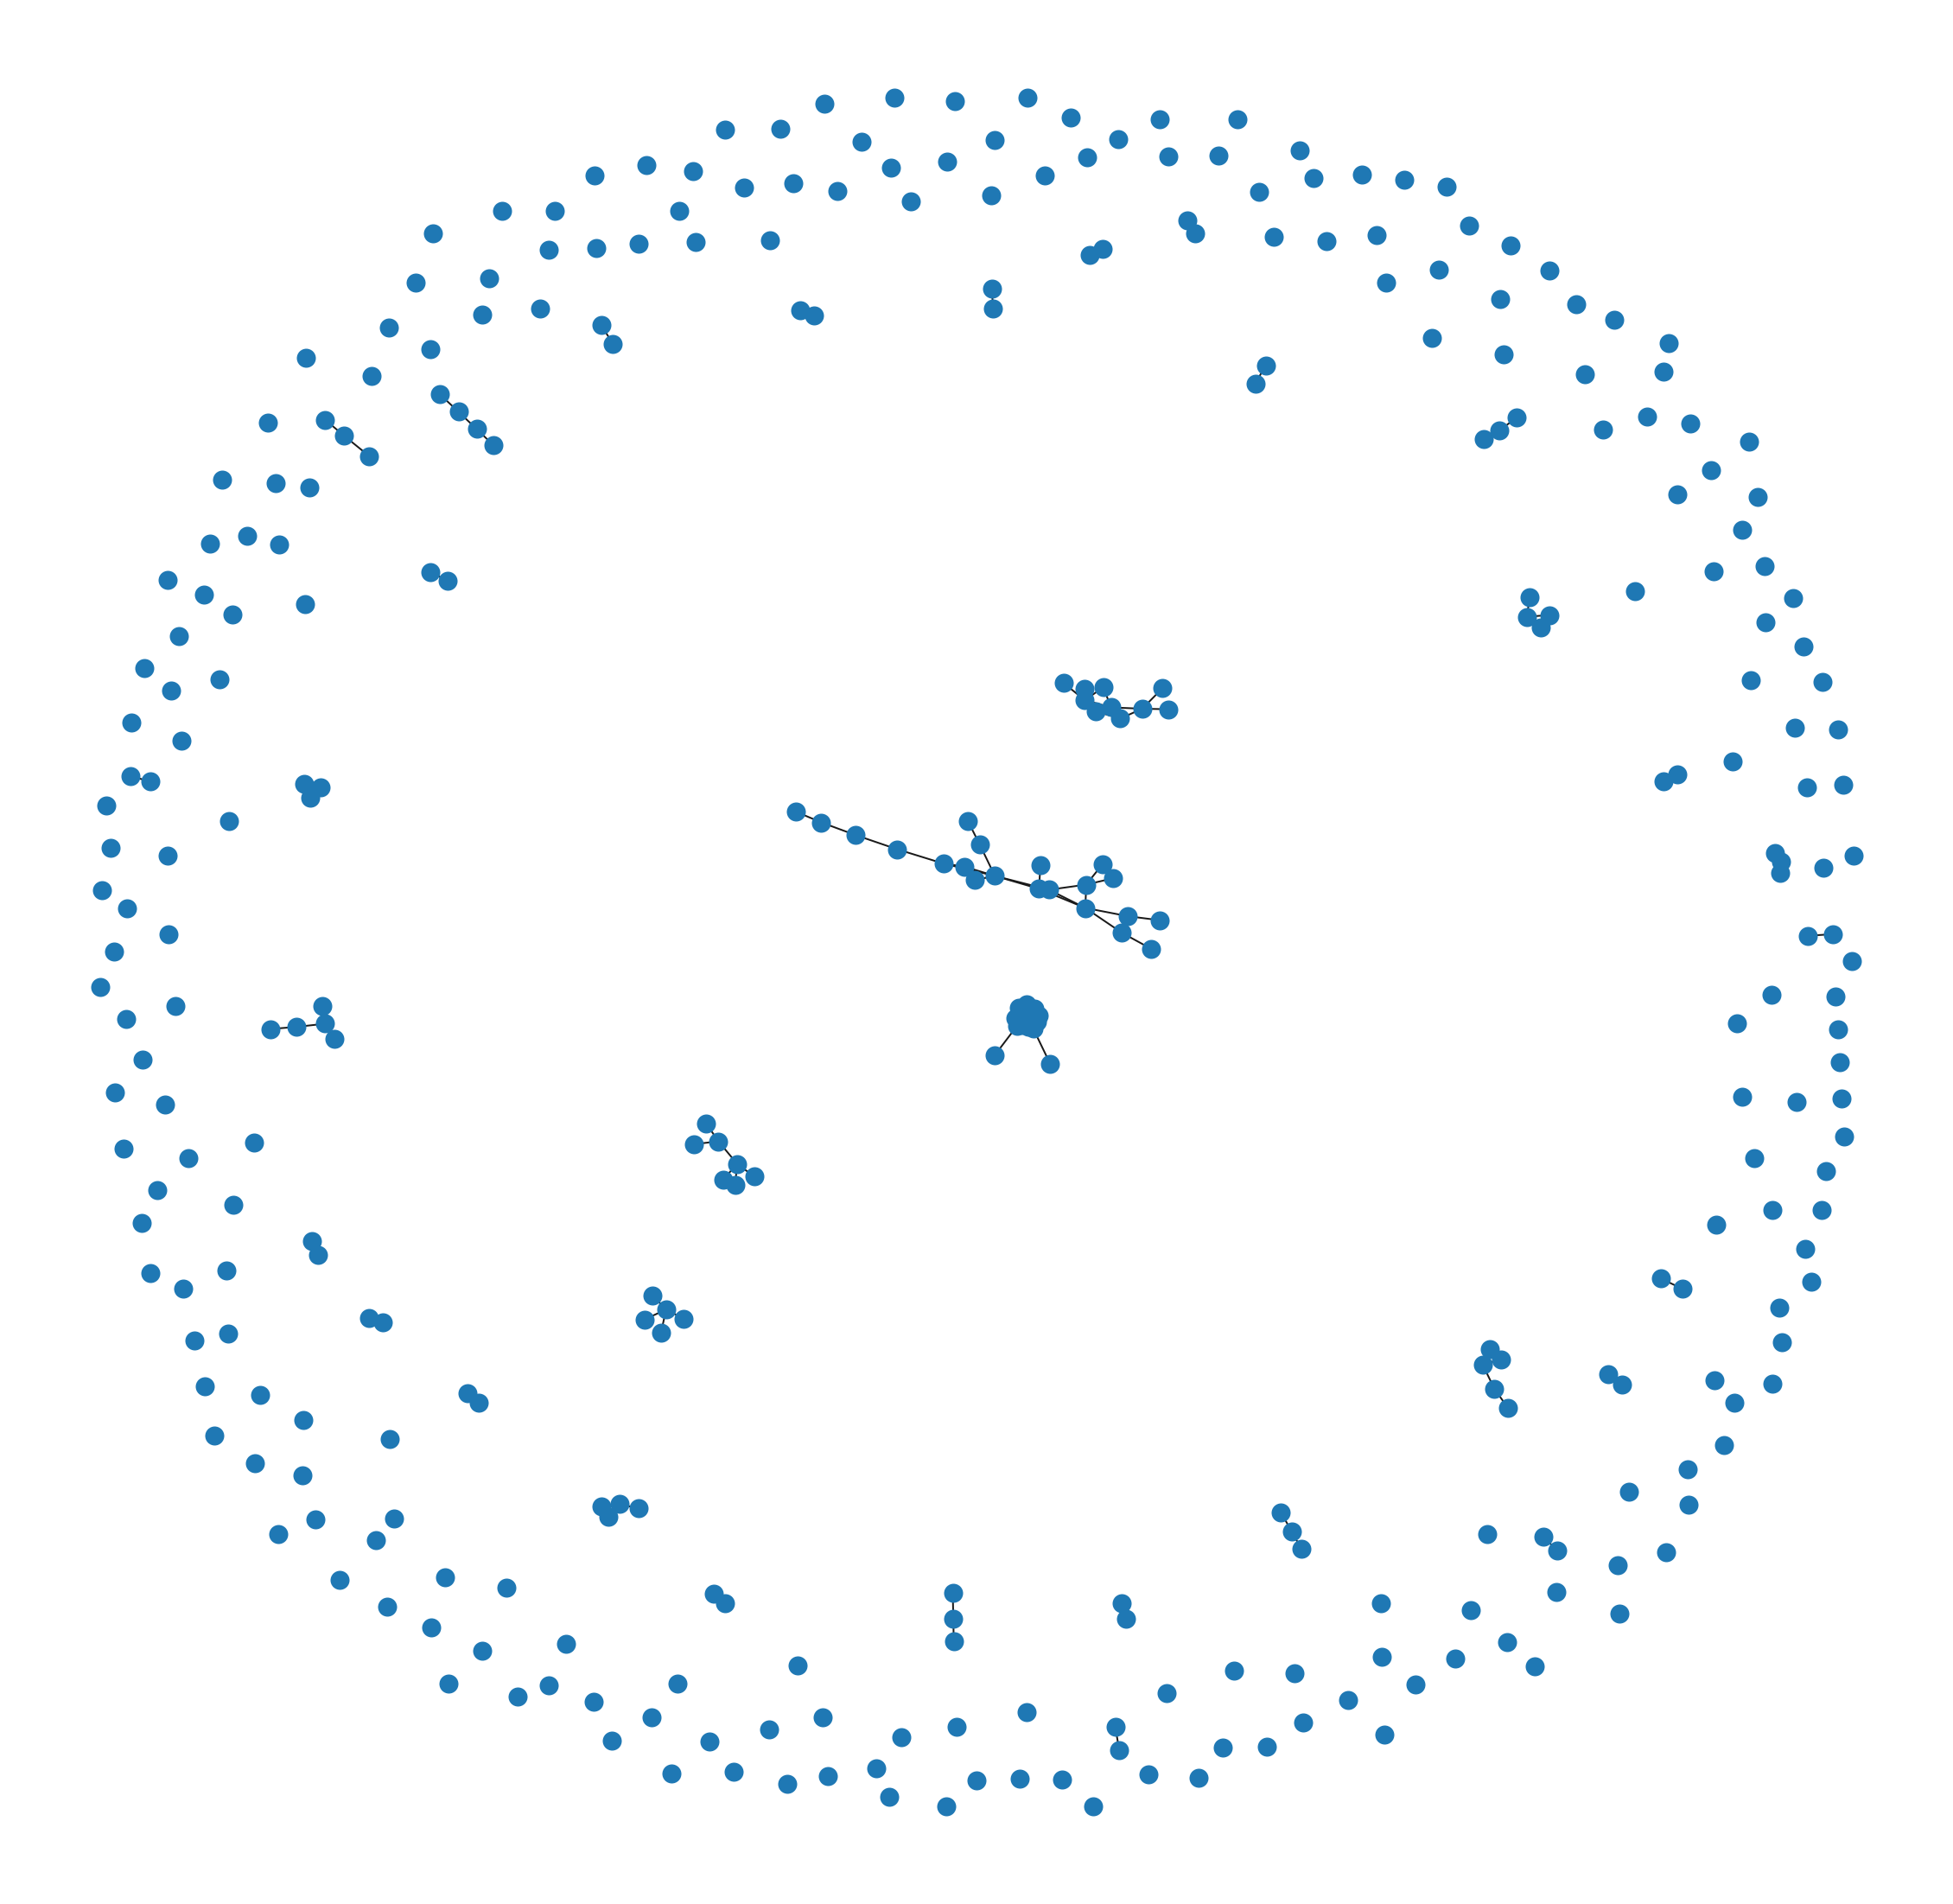

In [14]:
# look at projected graph (on hosts)
host_nodes = subset.host_id.unique()
B = bipartite.projected_graph(G, host_nodes)

pos = nx.spring_layout(B, seed=6)
labels = {node: labels_dict[node] for node in B.nodes}

# create plot
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(B, pos, node_size=100)
nx.draw_networkx_edges(B, pos, width=1)
# nx.draw_networkx_labels(B, pos, labels=labels, font_size=10, font_family="sans-serif")
plt.axis("off")
plt.show()

In [15]:
# identify the components with no links
components_one, n_one = component_size_one(B)
components_one = [item for sublist in components_one for item in sublist]

print("Number of components:\n", n_one)

Number of components:
 222


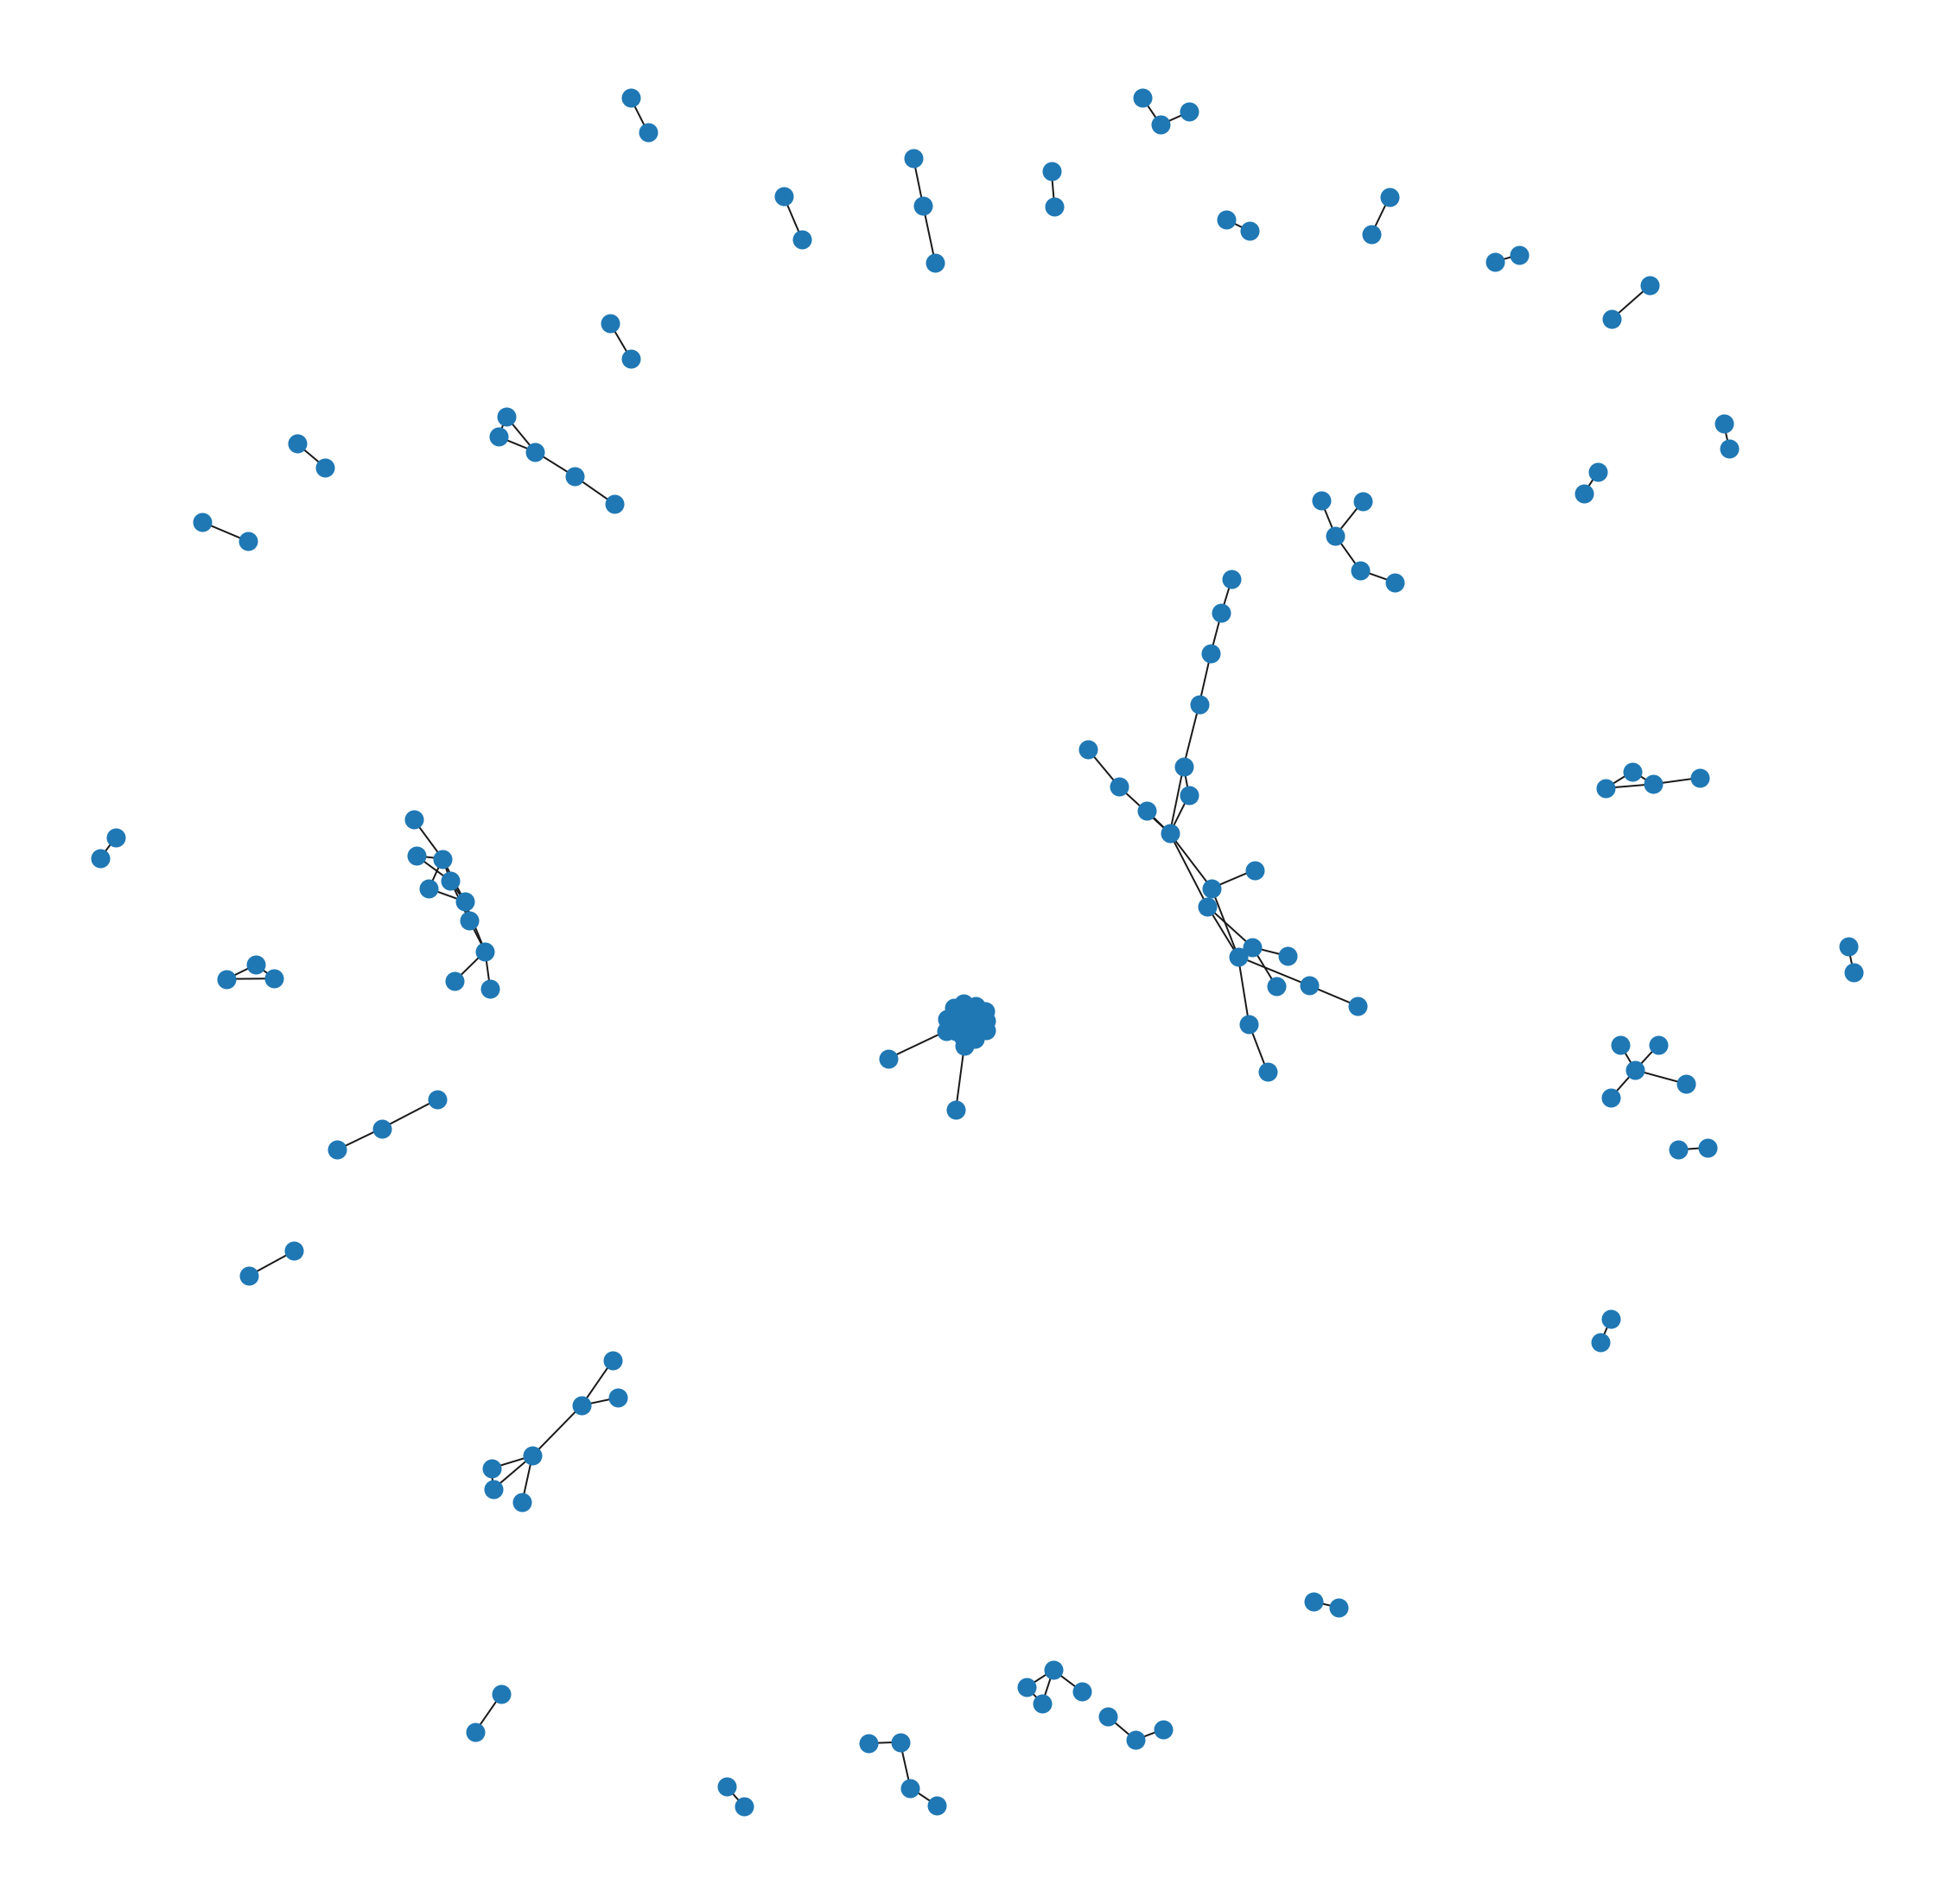

In [16]:
# remove the hosts with no links and plot the remaining ones
B.remove_nodes_from(components_one)

pos = nx.spring_layout(B, seed=1)
labels = {node: labels_dict[node] for node in B.nodes}

plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(B, pos, node_size=100)
nx.draw_networkx_edges(B, pos, width=1)
# nx.draw_networkx_labels(B, pos, labels=labels, font_size=11, font_family="sans-serif")
plt.axis("off")
plt.show()

### Investigate some of the connected components

In [17]:
GCC, components, n = giant_component_size(B)
print("Number of components:\n", n)

Number of components:
 35


#### Network 1

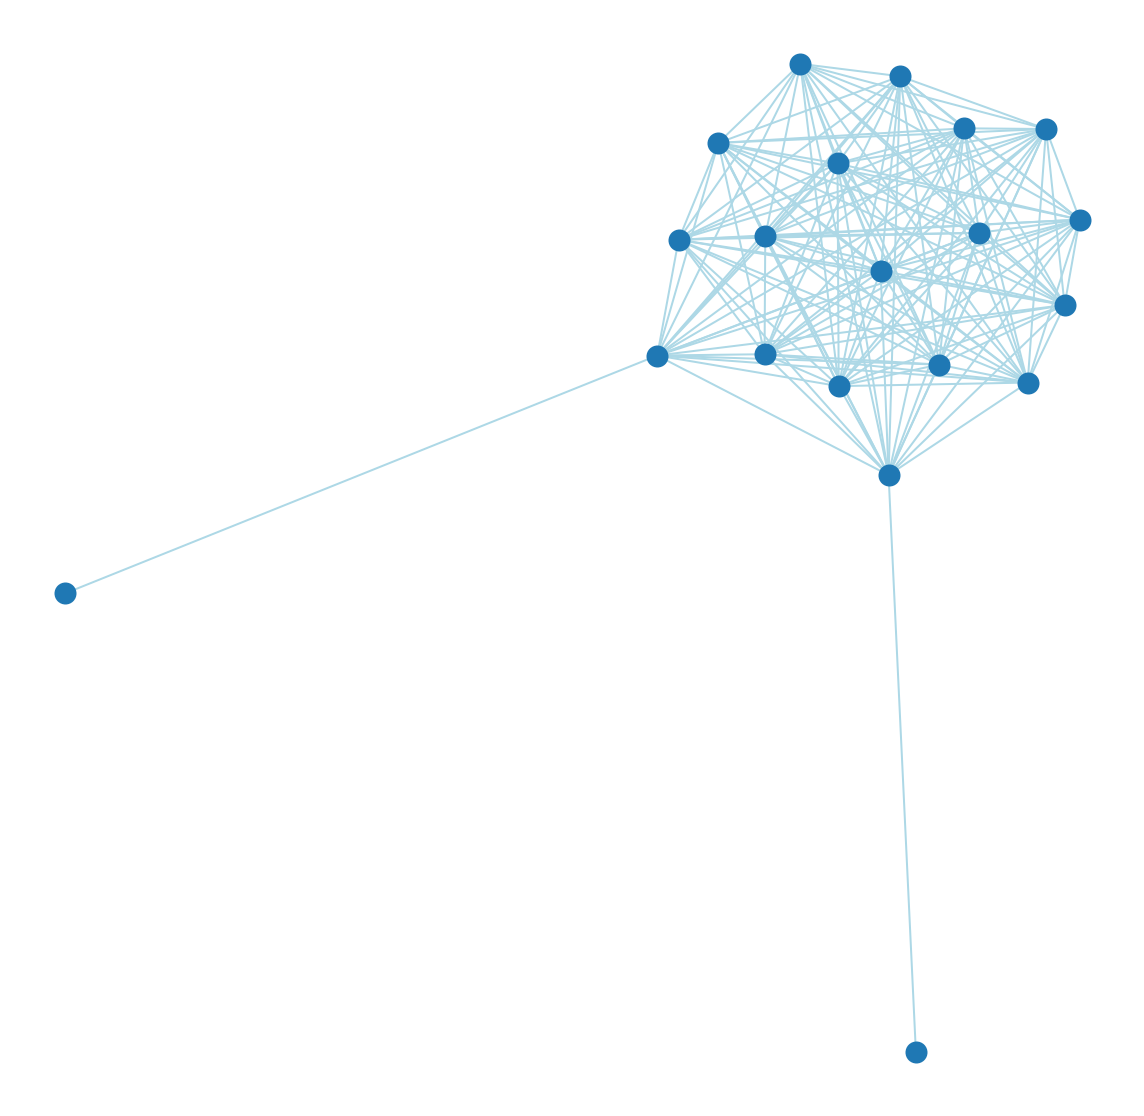

In [18]:
# plot one of the components
B_sub_1 = B.subgraph(components[12][1])

pos = nx.spring_layout(B_sub_1, seed=4)
labels = {node: labels_dict[node] for node in B_sub_1.nodes}

# create plot
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(B_sub_1, pos, node_size=100)
nx.draw_networkx_edges(B_sub_1, pos, width=1, edge_color='lightblue')
# nx.draw_networkx_labels(B_sub_1, pos, labels=labels, font_size=12, font_family="sans-serif")
plt.axis("off")
plt.show()

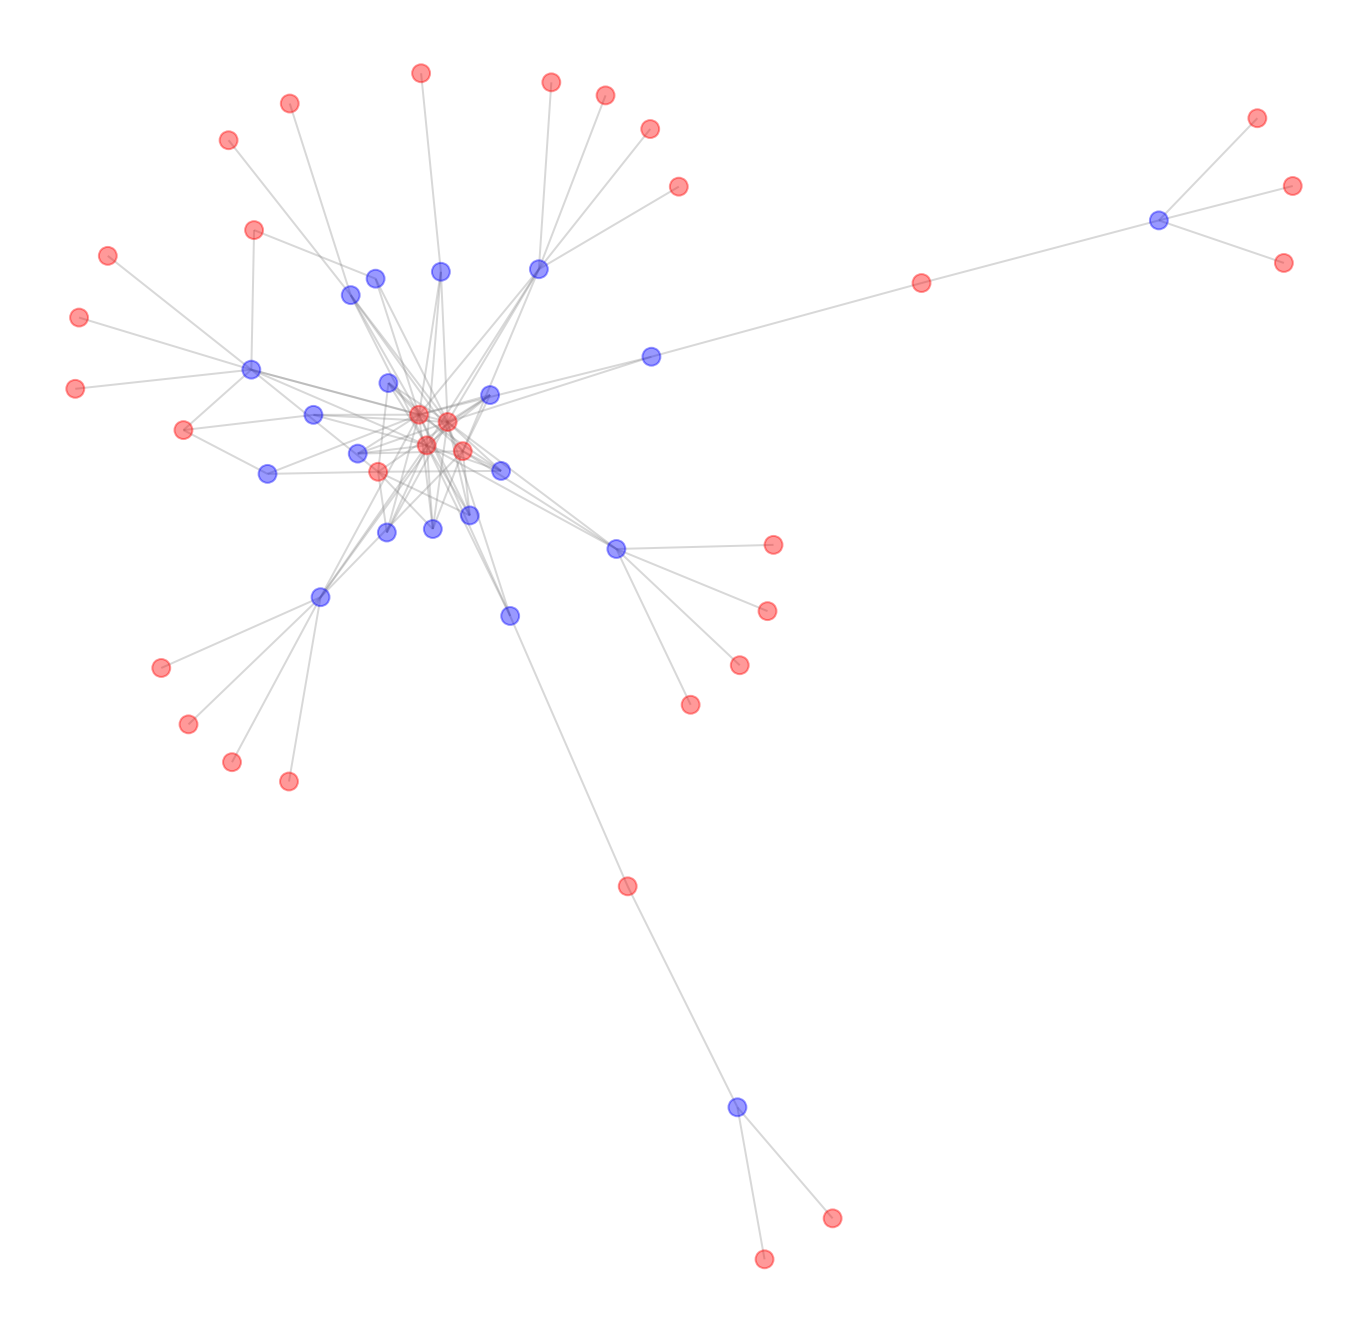

In [19]:
network_1 = subset[subset.host_id.isin(components[12][1])]

# plot network with reviewers added back in
G_net_1 = nx.Graph()
G_net_1.add_nodes_from(network_1.reviewer_id.unique(), bipartite=0)
G_net_1.add_nodes_from(network_1.host_id.unique(), bipartite=1)
G_net_1.add_edges_from(network_1[['reviewer_id', 'host_id']].values)

# nodes
reviewer_nodes = network_1.reviewer_id.unique()
host_nodes = network_1.host_id.unique()
labels = {node: labels_dict[node] for node in G_net_1.nodes}

# create plot
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_net_1, seed=6)
nx.draw_networkx_nodes(G_net_1, pos, node_size=80, node_color=['red']*len(reviewer_nodes) +
        ['blue']*(len(host_nodes)), alpha=0.4)
nx.draw_networkx_edges(G_net_1, pos, width=1, edge_color='grey', alpha=0.3)
# nx.draw_networkx_labels(G_net_1, pos, labels=labels, font_size=10, font_family="sans-serif")
plt.axis("off")
plt.show()

#### Network 2

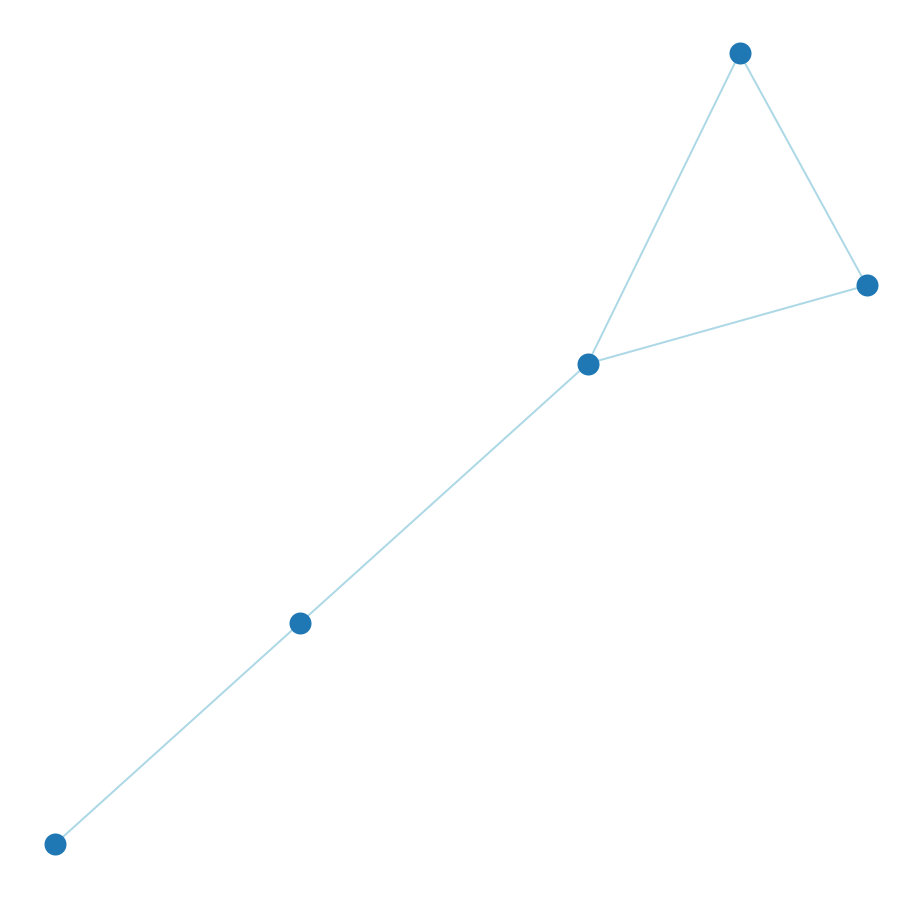

In [20]:
# plot one of the components
B_sub_2 = B.subgraph(components[20][1])

pos = nx.spring_layout(B_sub_2, seed=2)
labels = {node: labels_dict[node] for node in B_sub_2.nodes}

# create plot
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(B_sub_2, pos, node_size=100)
nx.draw_networkx_edges(B_sub_2, pos, width=1, edge_color='lightblue')
# nx.draw_networkx_labels(B_sub_2, pos, labels=labels, font_size=12, font_family="sans-serif")
plt.axis("off")
plt.show()

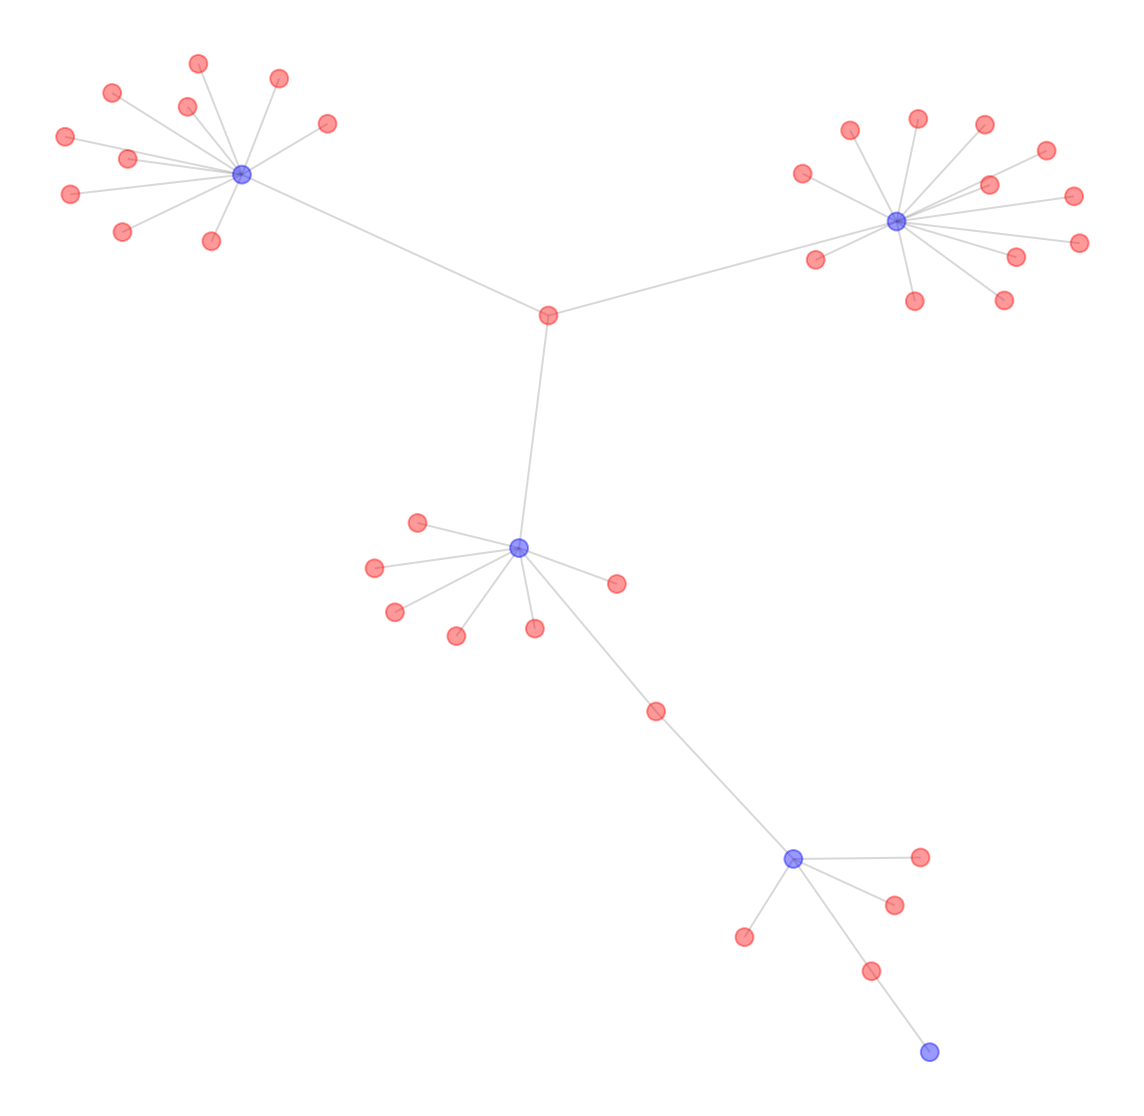

In [21]:
network_2 = subset[subset.host_id.isin(components[20][1])]

# plot network with reviewers added back in
G_net_2 = nx.Graph()
G_net_2.add_nodes_from(network_2.reviewer_id.unique(), bipartite=0)
G_net_2.add_nodes_from(network_2.host_id.unique(), bipartite=1)
G_net_2.add_edges_from(network_2[['reviewer_id', 'host_id']].values)

# nodes
reviewer_nodes = network_2.reviewer_id.unique()
host_nodes = network_2.host_id.unique()
labels = {node: labels_dict[node] for node in G_net_2.nodes}

# create plot
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_net_2, seed=1)
nx.draw_networkx_nodes(G_net_2, pos, node_size=80, node_color=['red']*len(reviewer_nodes) +
        ['blue']*(len(host_nodes)), alpha=0.4)
nx.draw_networkx_edges(G_net_2, pos, width=1, edge_color='grey', alpha=0.3)
# nx.draw_networkx_labels(G_net_2, pos, labels=labels, font_size=11, font_family="sans-serif")
plt.axis("off")
plt.show()

#### Network 3

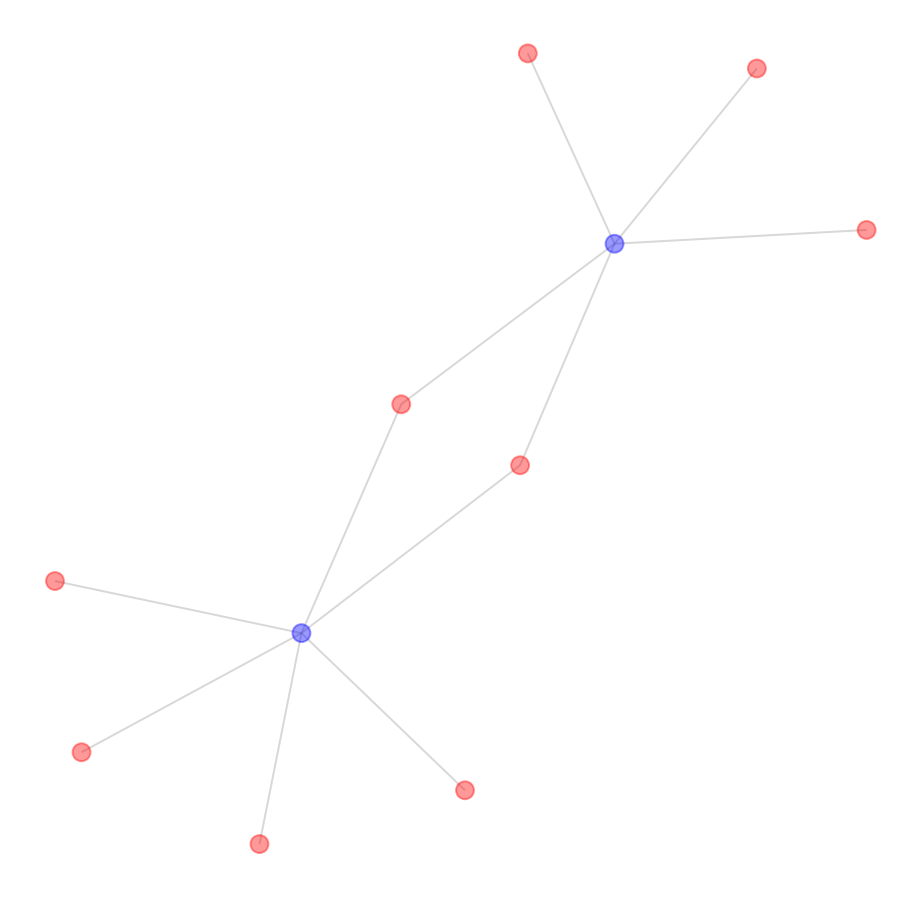

In [22]:
network_3 = subset[subset.host_id.isin(components[23][1])]

# plot network with reviewers added back in
G_net_3 = nx.Graph()
G_net_3.add_nodes_from(network_3.reviewer_id.unique(), bipartite=0)
G_net_3.add_nodes_from(network_3.host_id.unique(), bipartite=1)
G_net_3.add_edges_from(network_3[['reviewer_id', 'host_id']].values)

# nodes
reviewer_nodes = network_3.reviewer_id.unique()
host_nodes = network_3.host_id.unique()
labels = {node: labels_dict[node] for node in G_net_3.nodes}

# create plot
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G_net_3, seed=1)
nx.draw_networkx_nodes(G_net_3, pos, node_size=80, node_color=['red']*len(reviewer_nodes) +
        ['blue']*(len(host_nodes)), alpha=0.4)
nx.draw_networkx_edges(G_net_3, pos, width=1, edge_color='grey', alpha=0.3)
# nx.draw_networkx_labels(G_net_3, pos, labels=labels, font_size=11, font_family="sans-serif")
plt.axis("off")
plt.show()